In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)


In [3]:
# redshift bins
def Binningf(data_set):
    
    z_ds = data_set["redshift_true"]
    lnm_ds = np.log(data_set["m200c"])
    
    d = 0.05
    d_m = 0.25
    
    z_bins = int((max(z_ds) - min (z_ds)) // d  + 1)
    m_bins = int((max(lnm_ds) - min (lnm_ds)) // d_m + 1)

    z_0 = 0.0
    z_1 = d
    halos_bin_z =[]

    for i in range(z_bins):
        cut_z = np.logical_and (data_set['redshift_true'] > z_0, data_set['redshift_true'] < z_1)
        halos_bin_z.append(data_set[cut_z])
        z_0 = z_0 + d
        z_1 = z_1 + d

    # mass bins
    label = []
    halos_bin_mz =[]
    for i in range(z_bins):

        lnM_0 = min(lnM)
        lnM_1 = min(lnM) + d_m
        for j in range(m_bins):

            cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
            halos_bin_mz.append(halos_bin_z[i][cut])
            label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")

            lnM_0 = lnM_0 + d_m
            lnM_1 = lnM_1 + d_m
    
            lnM_1 = lnM_1 + d_m
    
    return halos_bin_mz

def bin_meanf(data_set):
    lnM_binned, z_binned, lnR_binned = [], [], [] 

    binned_halos = Binningf(data_set)

    for i in range(len(binned_halos)):

        halos = binned_halos[i]
        lnM_binned.append(np.log(halos["m200c"]))
        z_binned.append(halos["redshift_true"])
        lnR_binned.append(np.log(halos["richness"]))   

    lnR_mean, lnM_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 0], [np.mean(l) for l in lnM_binned if len(l) > 0], [np.mean(k) for k in z_binned if len(k) > 0]
    
    lnR_std = np.array([np.std(l) for l in lnR_binned if len(l) > 0])

    
    halos_mean = Table([np.exp(np.array(lnR_mean)), np.exp(np.array(lnM_mean)), z_mean],
               names=('richness', 'm200c', 'redshift_true'))
    
    return halos_mean, lnM_binned, z_binned, lnR_binned, lnR_std

In [4]:
dt_halos = Table(DC2_halos_m200c[1].data)
rmdata = create_richness_mass_calib(dt_halos)
    
model = Nc.ClusterMassLnrichExt(use_ln1pz = False)
#model.set_properties('use-ln1pz', False)

fixed_parameters = [12, 13, 14] 

#Model
model.param_set_by_name("cut", 1e15) #Set cut parameter value 
model.param_set_by_name("muM2", 1.0e-1) #Set cut parameter value 
model.param_set_by_name("muZ2", 1.0e-1) #Set cut parameter value 
mset = Ncm.MSet()
mset.set(model)
rmdata.m2lnL_val(mset)  
mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free
    
#Data
dset = Ncm.Dataset.new()
dset.append_data(rmdata)
    
    #Likelihood
lh = Ncm.Likelihood.new(dset)
  
    #All parameters free except cut parameters:
for par in fixed_parameters:
    mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)
    
mset.prepare_fparam_map()
    
    #Fit
fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
fit.log_info()
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit.log_info()
    
    #Binning data_set
bin_f= bin_meanf(dt_halos)
halos_mean = bin_f[0]
lnM_mean = np.log(halos_mean["m200c"])
z_mean = halos_mean["redshift_true"]
    
    # Mean and std of data_set z mean and lnM mean
lnR_mean_ext_z = np.array([model.get_mean_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
lnR_std_ext_z = np.array( [model.get_std_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0.1                 [FREE]
#   -    muZ2[04]:  0.1                 [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -     cut[12]:  1e+15               [FIX

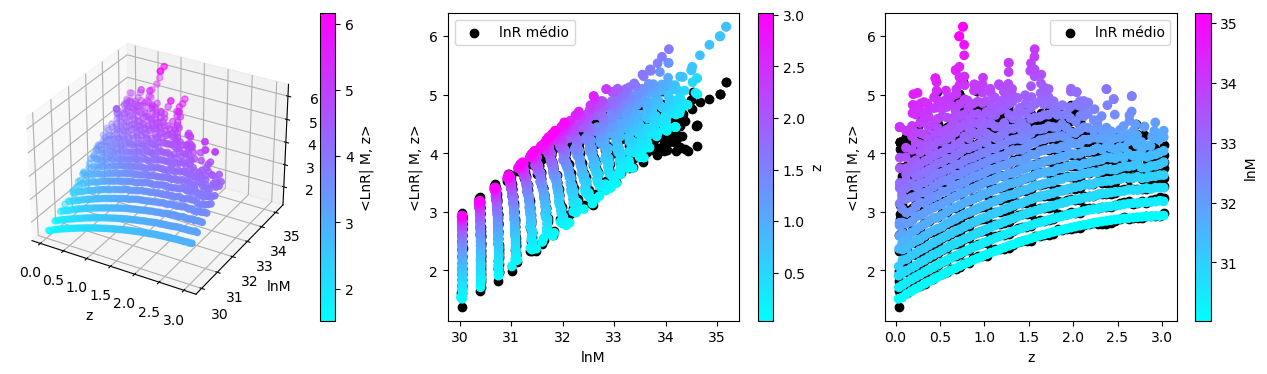

In [5]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

    #lnR model, z_mean, y_mean
halos_mean = bin_meanf(dt_halos)[0]
lnR_mean = np.log(halos_mean["richness"])
    
xs = halos_mean["redshift_true"]
ys = np.log(halos_mean["m200c"])
zs = lnR_mean_ext_z
    
p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
ax1.set_xlabel('z')
ax1.set_ylabel('lnM')
fig.colorbar(p1, ax=ax1, label='<LnR| M, z>')

ax2.scatter(ys, lnR_mean, c='k', label='lnR médio')
p2 = ax2.scatter(ys, zs , c= xs, cmap='cool')
ax2.set_xlabel('lnM')
ax2.set_ylabel('<LnR| M, z>')
fig.colorbar(p2, ax=ax2, label='z')
ax2.legend()

ax3.scatter(xs, lnR_mean, c='k', label='lnR médio')
p3 = ax3.scatter(xs, zs , c=ys, cmap='cool') 
ax3.set_xlabel('z')
ax3.set_ylabel('<LnR| M, z>')
fig.colorbar(p3, ax=ax3, label='lnM')
ax3.legend()